# Ensemble Learning

In [1]:
import numpy as np
from sklearn import tree, svm, ensemble, model_selection, metrics
import matplotlib.pyplot as plt

def my_linspace (min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace (min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

data = np.loadtxt('nonlinear.txt', delimiter = ',')
x = data[:,:2]
y = data[:,2].astype(int)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=2018)

color = ['blue', 'red']
y_train_color = [color[i] for i in y_train]
y_test_color = [color[i] for i in y_test]

steps = 200
x0 = my_linspace(min(x[:,0]), max(x[:,0]), steps)
x1 = my_linspace(min(x[:,1]), max(x[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]

# Bagging

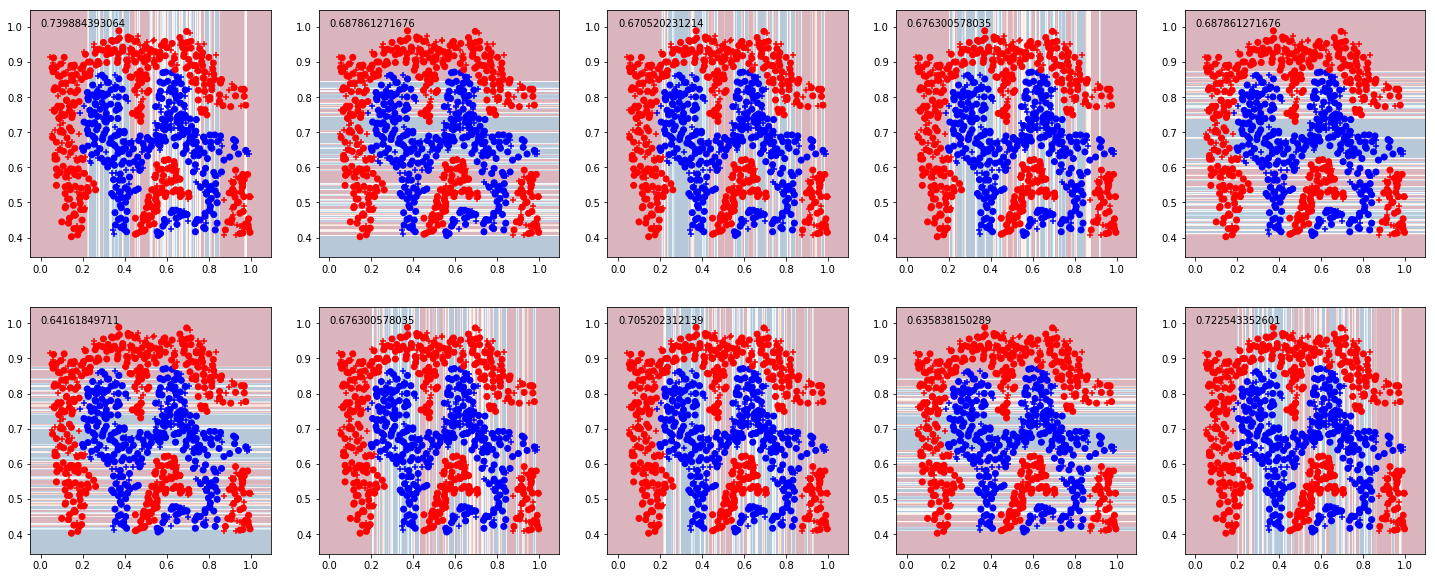

In [2]:
bagging = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_samples = 0.5, max_features = 1, oob_score = True, random_state = 2018)
bagging.fit(x_train, y_train)

plt.figure(figsize = (25, 10))
for i in range(bagging.n_estimators):
    plt.subplot(2, 5, i+1)
    mesh_prob = bagging.estimators_[i].predict_proba(mesh_data[:,bagging.estimators_features_[i]]).reshape(steps, steps, 2)
    plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
    plt.text(0, 1, bagging.estimators_[i].score(x_test[:,bagging.estimators_features_[i]], y_test))

plt.show()

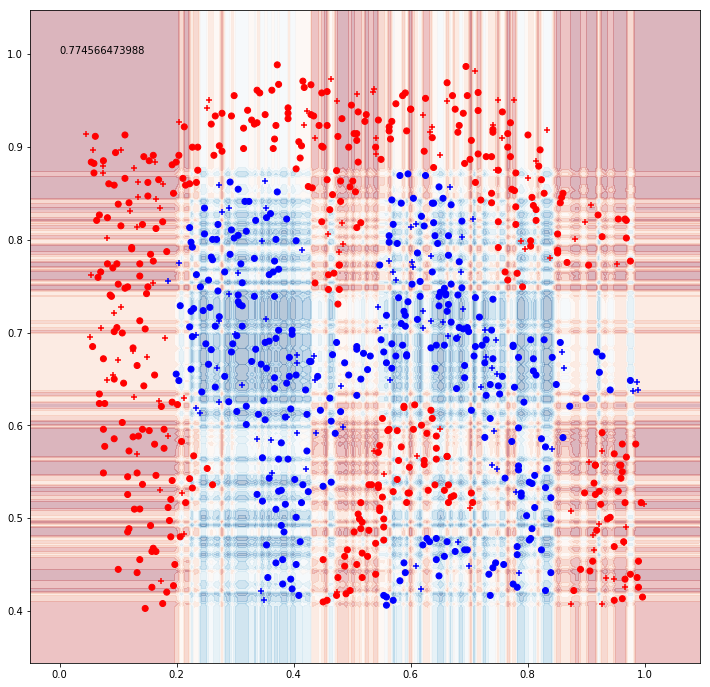

In [3]:
plt.figure(figsize = (12, 12))
mesh_prob = bagging.predict_proba(mesh_data).reshape(steps, steps, 2)
plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
plt.text(0, 1, bagging.score(x_test, y_test))
plt.show()

# Random Forest

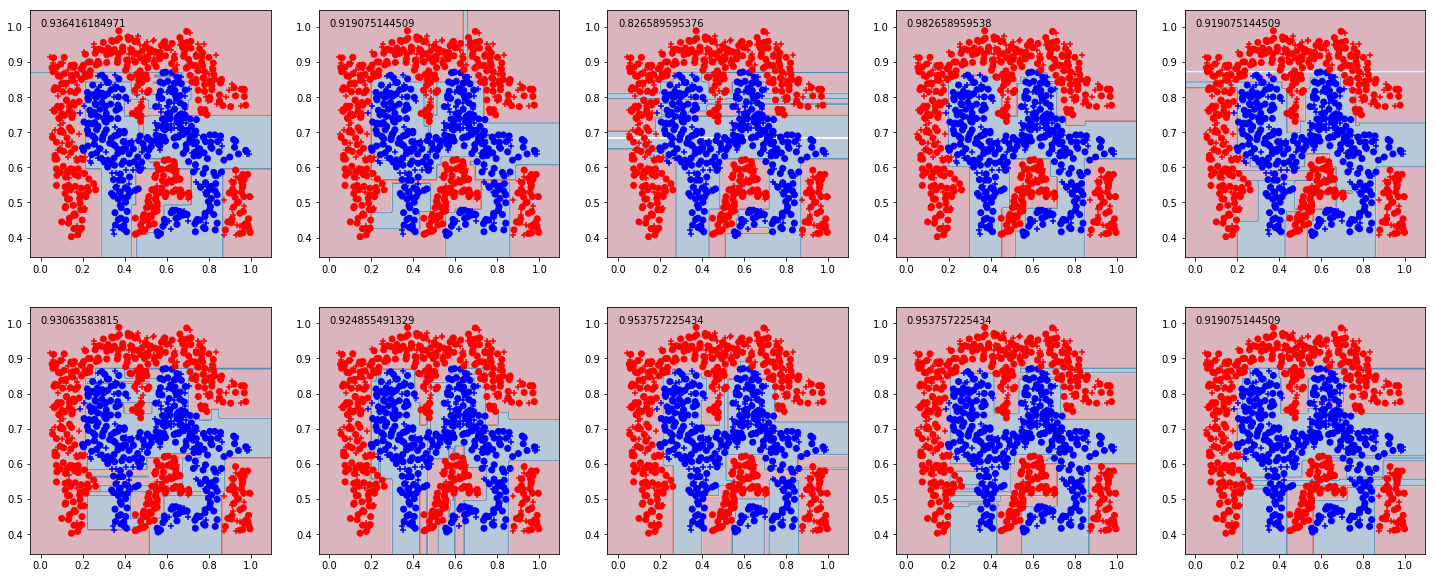

In [4]:
rforest = ensemble.RandomForestClassifier(max_features = 1, oob_score = True, random_state = 2018)
rforest.fit(x_train, y_train)

plt.figure(figsize = (25, 10))
for i in range(rforest.n_estimators):
    plt.subplot(2, 5, i+1)
    mesh_prob = rforest.estimators_[i].predict_proba(mesh_data).reshape(steps, steps, 2)
    plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
    plt.text(0, 1, rforest.estimators_[i].score(x_test, y_test))

plt.show()

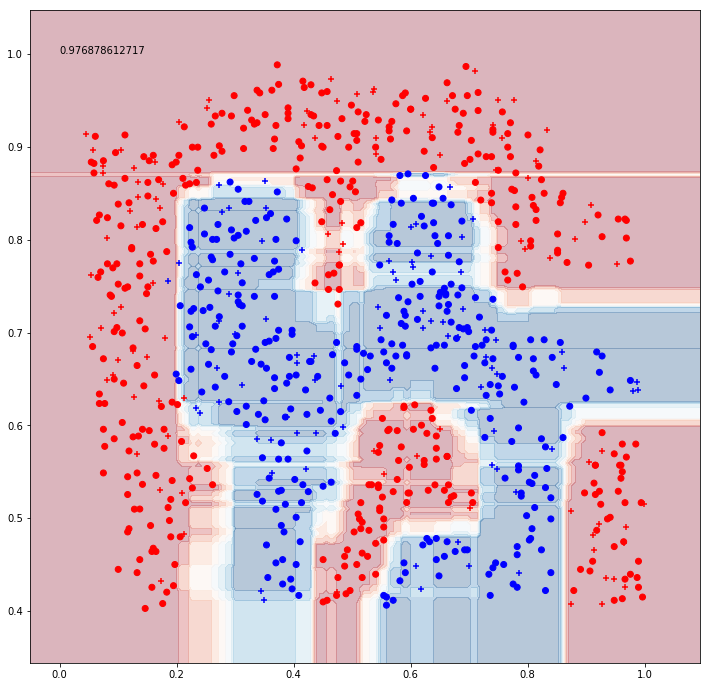

In [5]:
plt.figure(figsize = (12, 12))
mesh_prob = rforest.predict_proba(mesh_data).reshape(steps, steps, 2)
plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
plt.text(0, 1, rforest.score(x_test, y_test))
plt.show()

# Extra Trees

In [6]:
extree = ensemble.ExtraTreesClassifier(max_features = 1, bootstrap = True, oob_score = True, random_state = 2018)
extree.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=2018, verbose=0, warm_start=False)

# AdaBoost

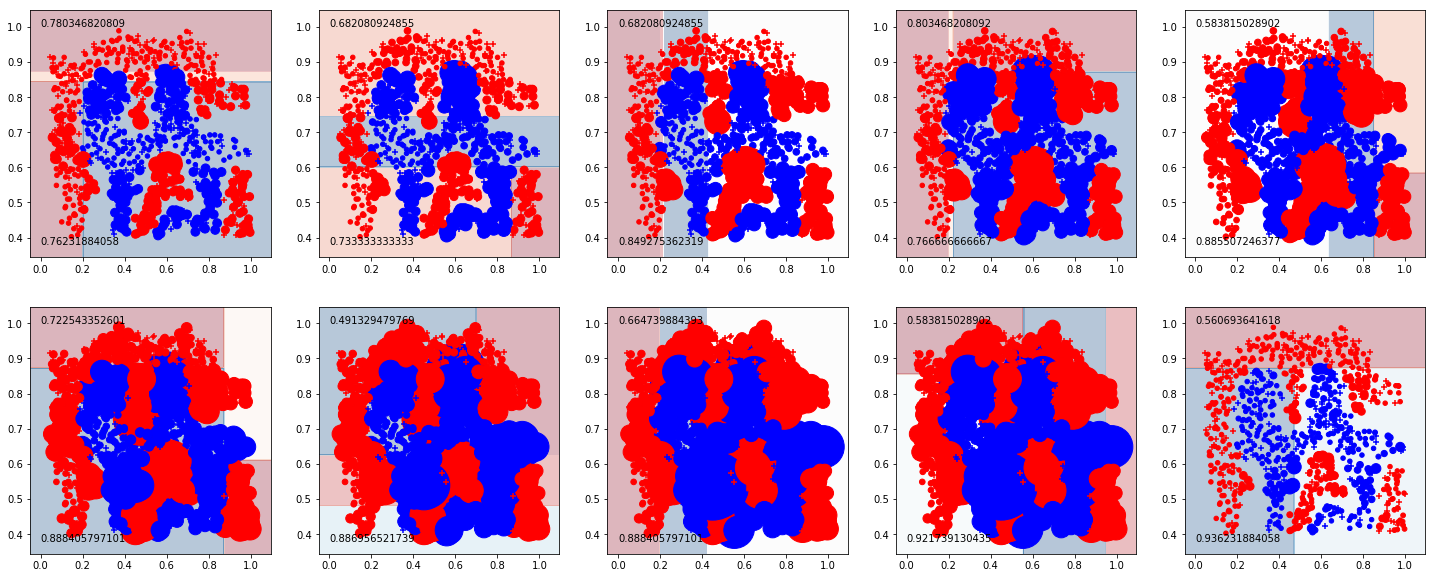

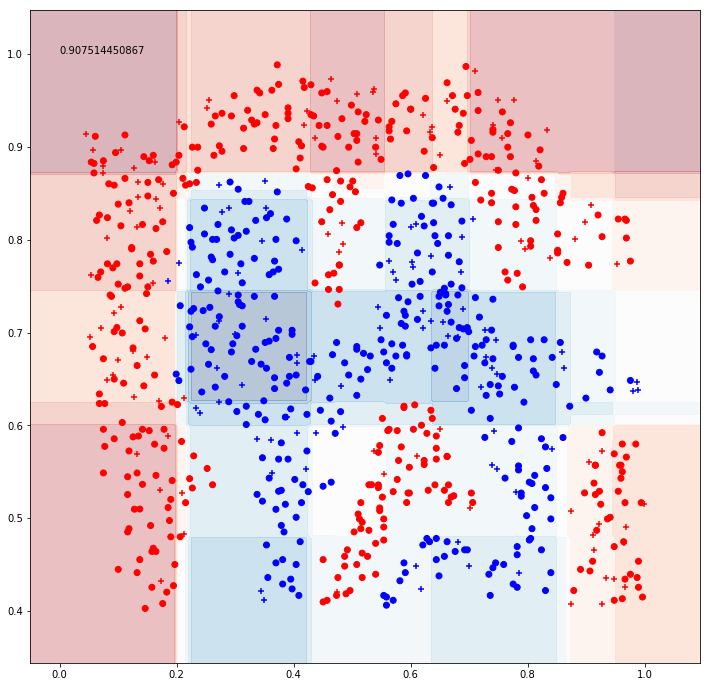

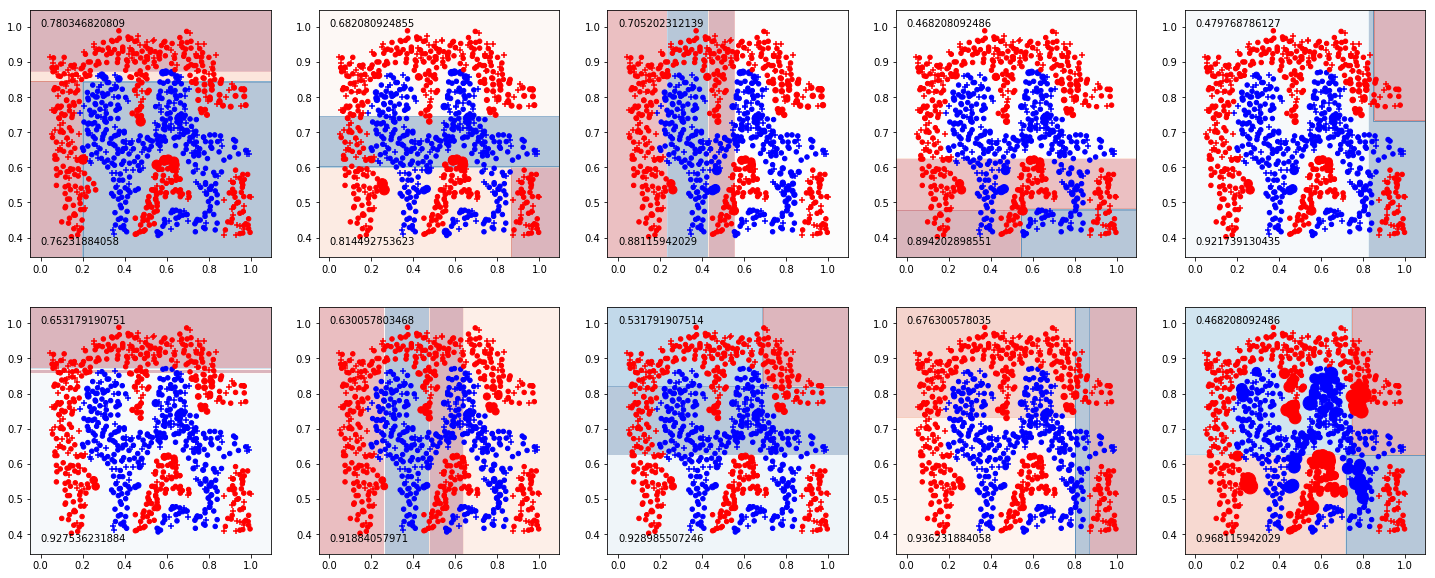

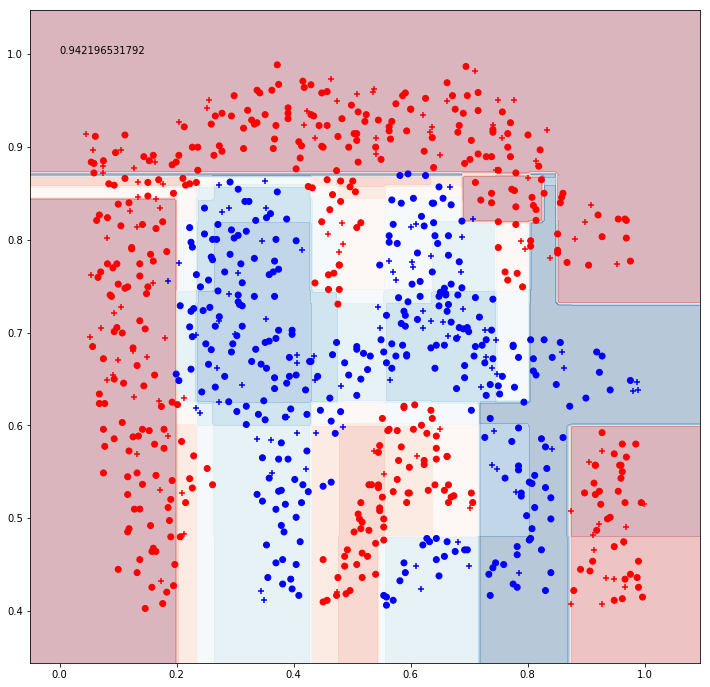

In [7]:
adaboost = [
    ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth = 2), n_estimators = 10, algorithm ='SAMME', random_state = 2018),
    ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth = 2), n_estimators = 10, algorithm ='SAMME.R', random_state = 2018)]

staged_score = [0.0] * 2
sample_weight = np.zeros((2, 10, x_train.shape[0]))
sample_weight[:, 0, :] = 1.0 / x_train.shape[0]
for i in range(2):
    adaboost[i].fit(x_train, y_train)
    staged_score[i] = [j for j in adaboost[i].staged_score(x_train, y_train)]
    for j in range(adaboost[i].n_estimators):
        sample_weight[i][j], estimator_weight, estimator_error = adaboost[i]._boost(j, x_train, y_train, sample_weight[i][max(0,j-1)], random_state = 2018)
    sample_weight_sum = np.sum(sample_weight[i][j])
    sample_weight[i][j] /= sample_weight_sum

for i in range(2):
    plt.figure(figsize = (25, 10))
    for j in range(adaboost[i].n_estimators):
        plt.subplot(2, 5, j+1)
        mesh_prob = adaboost[i].estimators_[j].predict_proba(mesh_data).reshape(steps, steps, 2)
        plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
        plt.scatter(x_train[:,0], x_train[:,1], s=[np.maximum(20, 20 * sample_weight[i,j,:] * x_train.shape[0])], c=y_train_color)
        plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
        plt.text(0, 1, adaboost[i].estimators_[j].score(x_test, y_test))
        plt.text(0, 0.38, staged_score[i][j])
    
    plt.show()
    
    plt.figure(figsize = (12, 12))
    mesh_prob = adaboost[i].predict_proba(mesh_data).reshape(steps, steps, 2)
    plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
    plt.text(0, 1, adaboost[i].score(x_test, y_test))
    plt.show()

# Gradient Boost

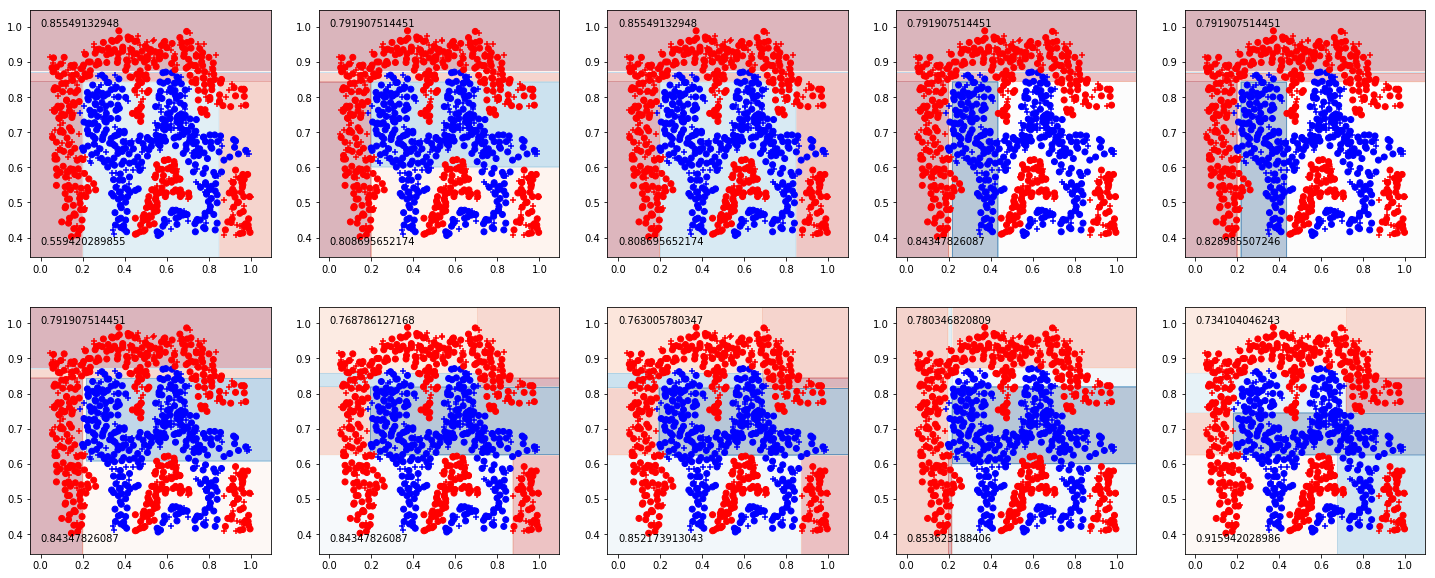

In [8]:
gboost = ensemble.GradientBoostingClassifier(n_estimators = 10, random_state = 2018)
gboost.fit(x_train, y_train)
staged_pred = [i for i in gboost.staged_predict(x_train)]

plt.figure(figsize = (25, 10))
for i in range(gboost.n_estimators):
    plt.subplot(2, 5, i+1)
    mesh_prob = gboost.estimators_[i][0].predict(mesh_data).reshape(steps, steps)
    plt.contourf(xx0, xx1, -mesh_prob[:,:], 10, cmap=plt.cm.RdBu, alpha=0.3)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
    plt.text(0, 1, metrics.accuracy_score(y_test, gboost.estimators_[i][0].predict(x_test) > 0))
    plt.text(0, 0.38, metrics.accuracy_score(y_train, staged_pred[i]))

plt.show()

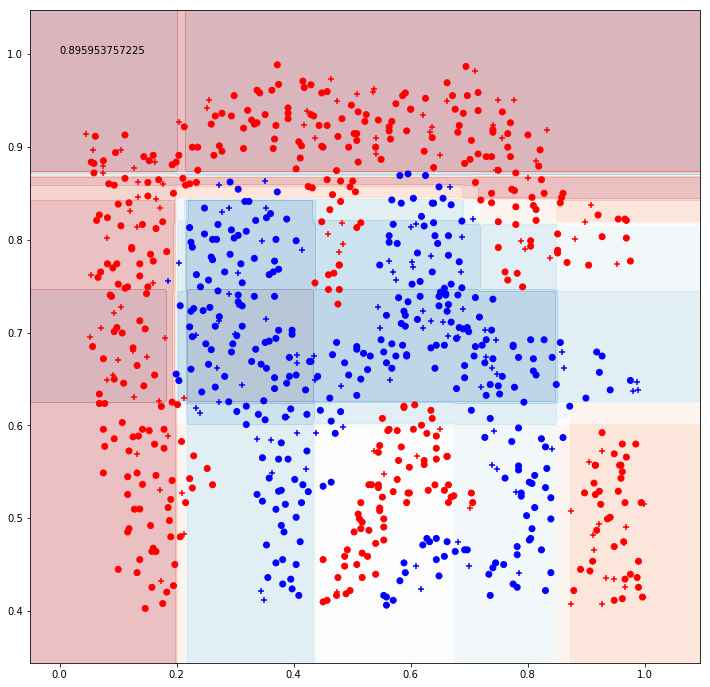

In [9]:
plt.figure(figsize = (12, 12))
mesh_prob = gboost.predict_proba(mesh_data).reshape(steps, steps, 2)
plt.contourf(xx0, xx1, mesh_prob[:,:,0], 10, cmap=plt.cm.RdBu, alpha=0.3)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_color)
plt.scatter(x_test[:,0], x_test[:,1], c=y_test_color, marker='+')
plt.text(0, 1, gboost.score(x_test, y_test))
plt.show()